In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import corner
import h5py
import lal
import pystan
import scipy.linalg as sl
import scipy.signal as sig
import scipy.stats as ss
import seaborn as sns
import qnm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

INFO:root:Could not load Schw QNM dict from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/schwarzschild/data/Schw_dict.pickle


Here is a fair draw from GW150914 posteriors (couldn't make it work with values in the paper, testing random posterior):

In [114]:
ra = 1.111
dec = -1.186
psi = 2.022
cos_iota = -0.9673

tgps_H = 1126259462.4216 # Empirical maximum (rounded down, to ensure we get the right sample)

dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))
dt_L = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['L1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))

tgps_geocent = tgps_H - dt_H
tgps_L = tgps_geocent + dt_L

gmst = lal.GreenwichMeanSiderealTime(lal.LIGOTimeGPS(tgps_H))
FpH, FcH = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['H1'].response, ra, dec, psi, gmst)
FpL, FcL = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['L1'].response, ra, dec, psi, gmst)

In [115]:
FpH, FcH, FpL, FcL

(0.062155603790214106,
 -0.5639259446151951,
 -0.18029421876826163,
 0.4324724493428632)

In [116]:
with h5py.File('H-H1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Hstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Hts = linspace(T0, T0+32-1.0/4096, Hstrain.shape[0])

with h5py.File('L-L1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Lstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Lts = linspace(T0, T0+32-1/4096, Lstrain.shape[0])
    
fny = 1.0/(Hts[1]-Hts[0])/2.0

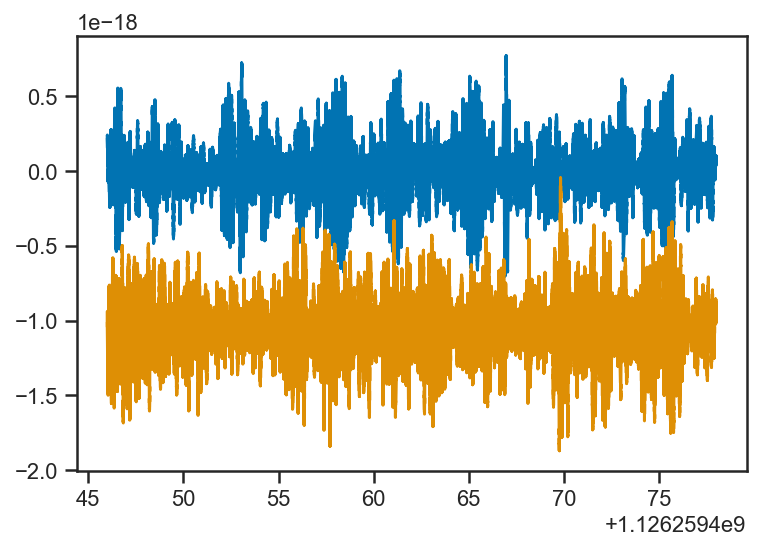

In [117]:
plot(Hts, Hstrain, label='H')
plot(Lts, Lstrain, label='L')

In [155]:
b, a = sig.butter(4, [20/fny, 1024/fny], btype='bandpass', output='ba')
Hfilt = sig.filtfilt(b, a, Hstrain)
Lfilt = sig.filtfilt(b, a, Lstrain)
Htsfilt = Hts
Ltsfilt = Lts

inear_H = where(Htsfilt > tgps_H)[0][0]
inear_L = where(Ltsfilt > tgps_L)[0][0]

# Ensure that we keep the sample that is nearest to, but beyond, tgps_{H,L}
Htsfilt = Htsfilt[(inear_H%2)::2]
Hfilt = Hfilt[(inear_H%2)::2]
Ltsfilt = Ltsfilt[(inear_L%2)::2]
Lfilt = Lfilt[(inear_L%2)::2]

# Grab starting from the first sample *after* merger
I0H = where(Htsfilt > tgps_H)[0][0]
I0L = where(Ltsfilt > tgps_L)[0][0]

gamma_min = 100
min_decay = 10
Nanalyze = int(round(min_decay / (gamma_min*(Htsfilt[1]-Htsfilt[0]))))
Tanalyze = Nanalyze*(Htsfilt[1]-Htsfilt[0])
print('Will analyze {:.3f} s of data'.format(Tanalyze))

Will analyze 0.100 s of data


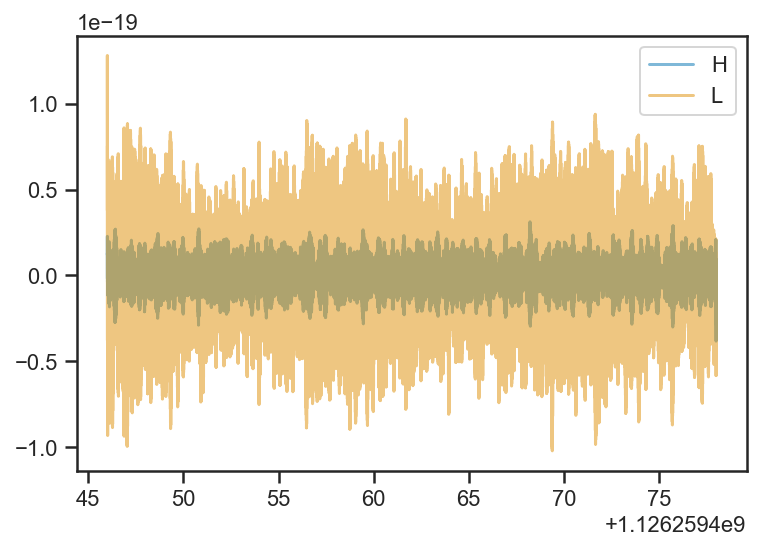

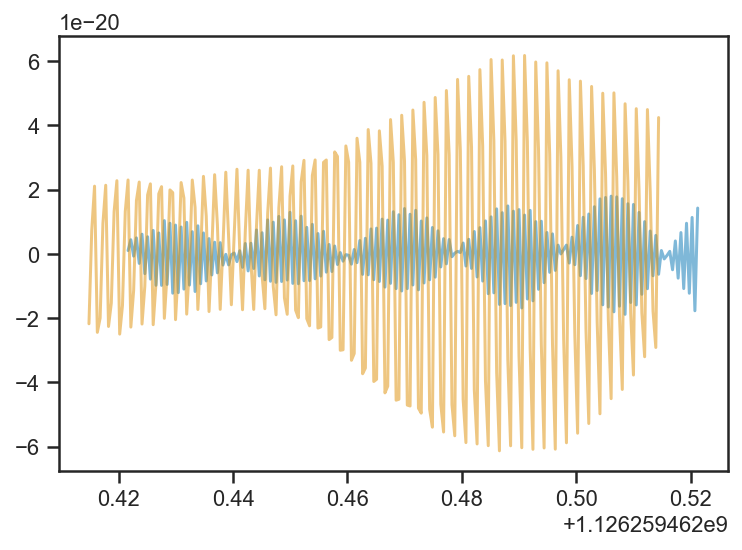

In [156]:
plot(Htsfilt, Hfilt, label='H', alpha=0.5)
plot(Ltsfilt, Lfilt, label='L', alpha=0.5)

legend(loc='best')

figure()
plot(Htsfilt[I0H:I0H+Nanalyze], Hfilt[I0H:I0H+Nanalyze], label='H', alpha=0.5)
plot(Ltsfilt[I0L:I0L+Nanalyze], Lfilt[I0L:I0L+Nanalyze], label='L', alpha=0.5)

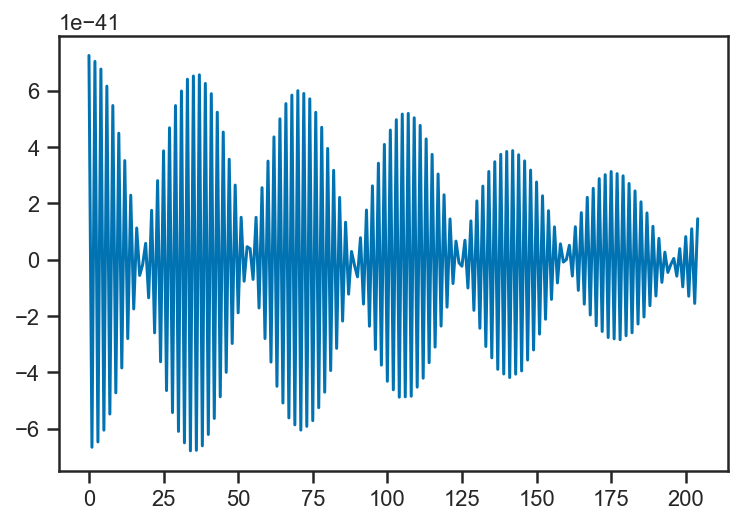

In [157]:
Hrho = sig.correlate(Hfilt, Hfilt)
Hrho = ifftshift(Hrho)
Hrho = Hrho / len(Hfilt)
plot(Hrho[:Nanalyze])

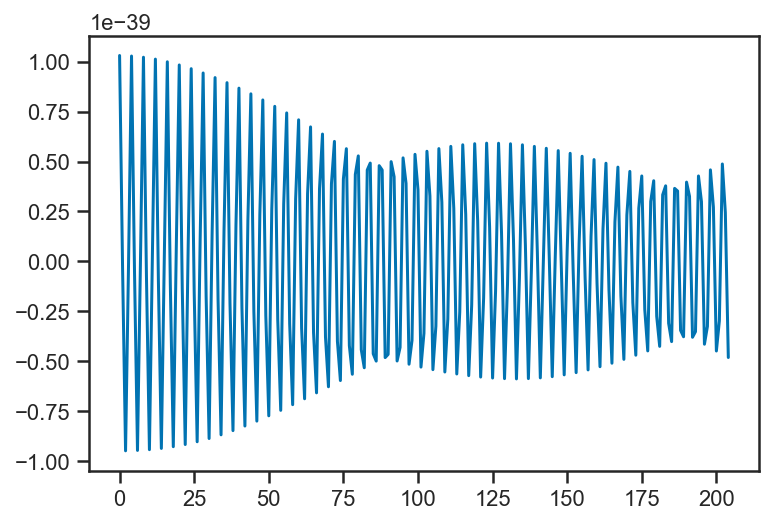

In [158]:
Lrho = sig.correlate(Lfilt, Lfilt)
Lrho = ifftshift(Lrho)
Lrho = Lrho / len(Lfilt)
plot(Lrho[:Nanalyze])

In [159]:
HC = sl.toeplitz(Hrho[:Nanalyze])
HCorr = sl.toeplitz(HC[0,:]/HC[0,0])
HL = np.linalg.cholesky(HC)
HCorrL = np.linalg.cholesky(HCorr)

LC = sl.toeplitz(Lrho[:Nanalyze])
LCorr = sl.toeplitz(LC[0,:]/LC[0,0])
LL = np.linalg.cholesky(LC)
LCorrL = np.linalg.cholesky(LCorr)

This is something like the GW150914 plot: whitened data, with L shifted and inverted.

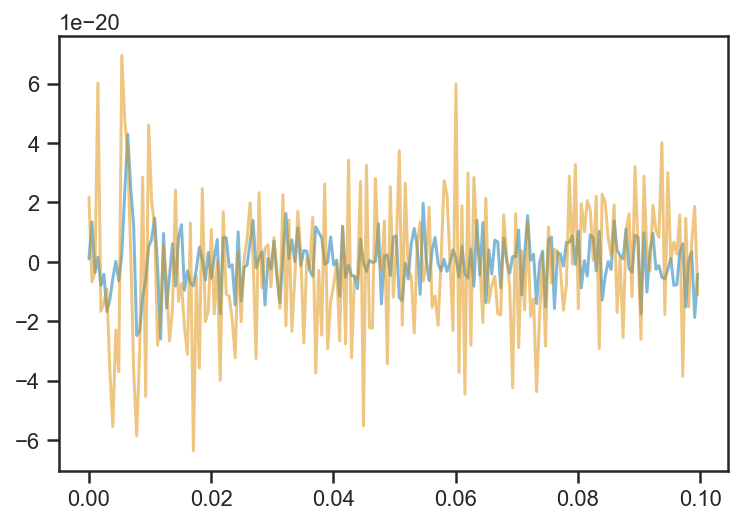

In [160]:
t = (Htsfilt[1]-Htsfilt[0])*arange(Nanalyze)
plot(t, np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), label='H', alpha=0.5)
plot(t, -np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), label='L', alpha=0.5)

In [161]:
x = randn(Nanalyze)
bHc = sl.cho_solve((HL, True), x)
bHt = sl.solve_toeplitz(Hrho[:Nanalyze], x)

In [162]:
x = randn(Nanalyze)
bLc = sl.cho_solve((LL, True), x)
bLt = sl.solve_toeplitz(Lrho[:Nanalyze], x)

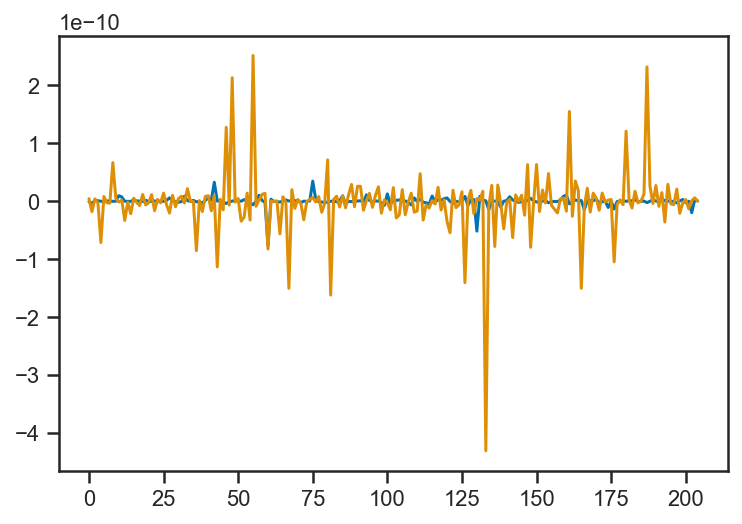

In [163]:
plot(2.0*(bHc-bHt)/(np.abs(bHc) + np.abs(bHt)))
plot(2.0*(bLc-bLt)/(np.abs(bLc) + np.abs(bLt)))

In [164]:
fref = 2.98e3 # Hz, at 68 MSun
chi0 = 0.69

g220 = qnm.modes_cache(-2, 2, 2, 0)
omega, _, _ = g220(a=chi0)
f0 = real(omega)/(2*pi) * fref
gamma0 = abs(imag(omega)) * fref

g221 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g221(a=chi0)
f1 = real(omega)/(2*pi) * fref
gamma1 = abs(imag(omega)) * fref

g222 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g222(a=chi0)
f2 = real(omega)/(2*pi) * fref
gamma2 = abs(imag(omega)) * fref

print('Given estimated tau0, expect signal to be down by exp(-{:.1f}) by end of data'.format(gamma0*Tanalyze))

Given estimated tau0, expect signal to be down by exp(-24.2) by end of data


In [207]:
model_constrained = pystan.StanModel(file='ringdown_constrained.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_635dced5a283f32e19bd4302cb8007ec NOW.
/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp1nirsj5k/stanfit4anon_model_635dced5a283f32e19bd4302cb8007ec_4344840141795985530.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [208]:
data_constrained = {
    'nobs': 2,
    'nsamp': Nanalyze,
    
    't0': [tgps_H, tgps_L],
    'ts': [Htsfilt[I0H:I0H+Nanalyze], Ltsfilt[I0L:I0L+Nanalyze]],
    'strain': [Hfilt[I0H:I0H+Nanalyze], Lfilt[I0L:I0L+Nanalyze]],
    'L': [HL, LL],
    
    'mu_logf': log(f0),
    'sigma_logf': 0.5,
    
    'mu_loggamma': log(gamma0),
    'sigma_loggamma': 0.5,
    
    'FpFc': [[FpH, FcH], [FpL, FcL]],
    'cos_inc': cos_iota,
    
    'Amax': 1e-19
}

In [209]:
fit_constrained = model_constrained.sampling(data=data_constrained)
fit_constrained = az.convert_to_inference_data(fit_constrained)

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f4c64a8>,
      dtype=object)

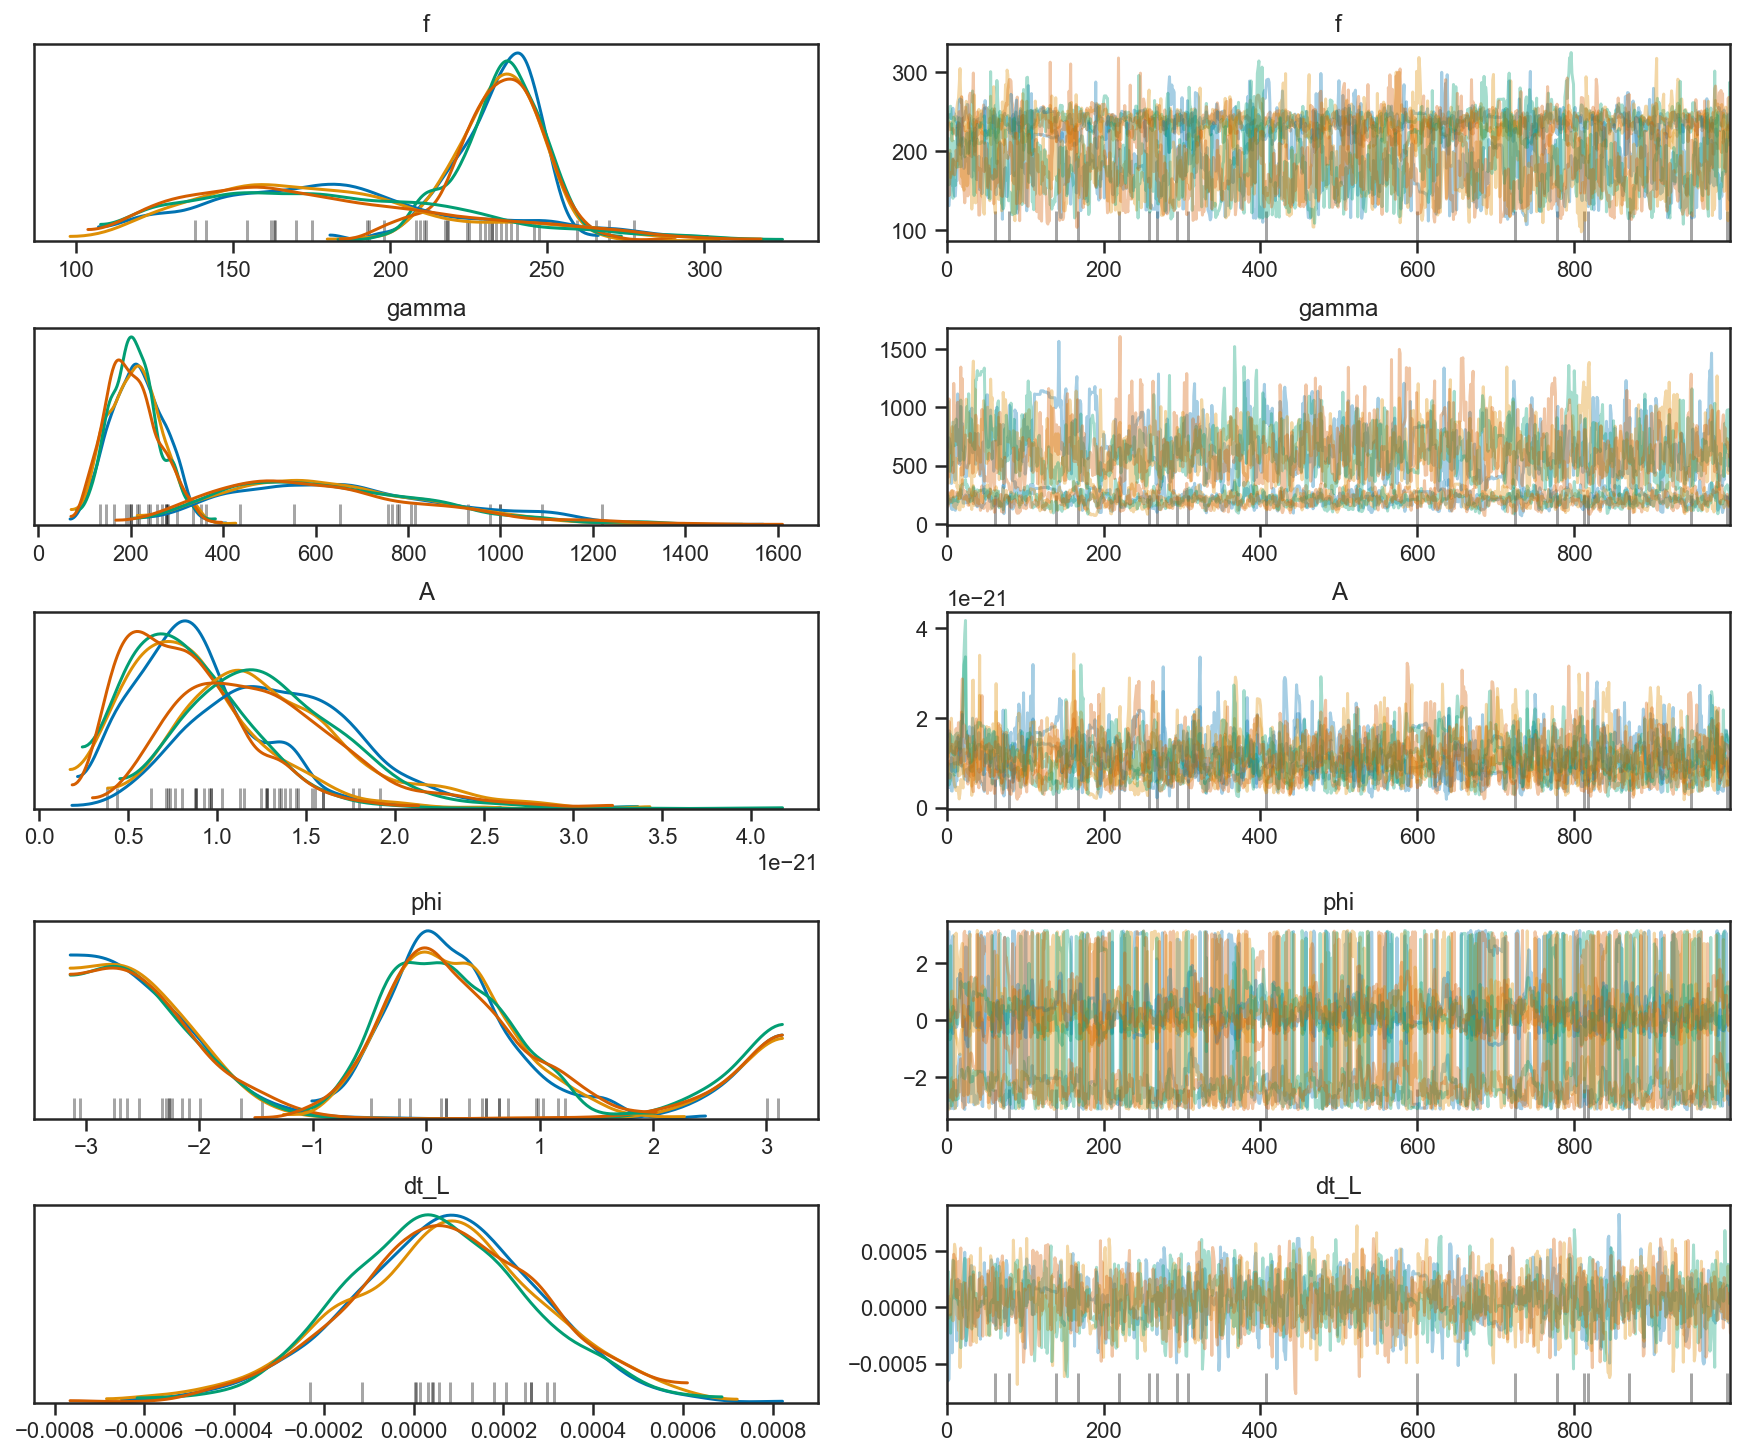

In [210]:
az.plot_trace(fit_constrained
              , var_names=['f', 'gamma', 'A', 'phi', 'dt_L'], compact=True)

In [200]:
az.to_netcdf(fit_constrained, 'GW150914.nc')

'GW150914.nc'

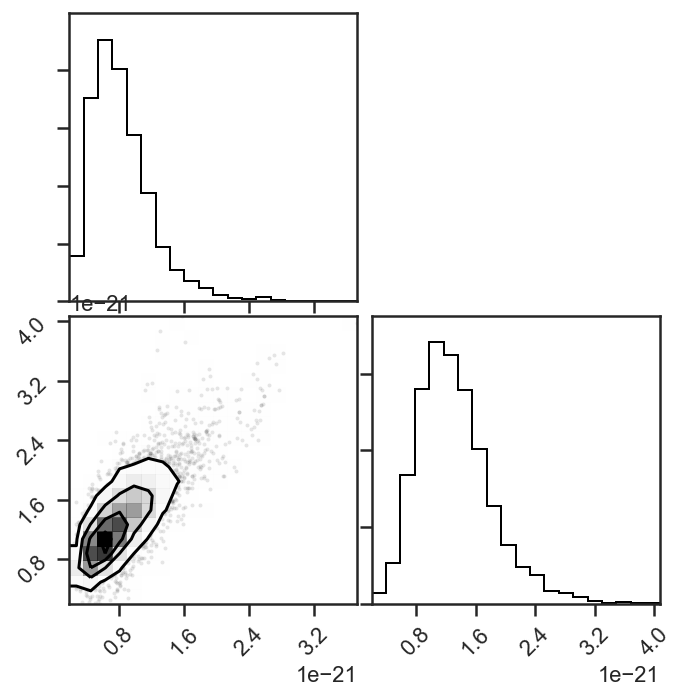

In [201]:
corner.corner(fit_constrained.posterior.A.values.reshape((-1, 2)),
              label=[r'$A_1$', r'$A_2$']);

This should be like the plot in the paper, but is not yet there.

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/arviz/plots/kdeplot.py:384: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


(<matplotlib.axes._subplots.AxesSubplot at 0x1523a6d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13d757ac8>)

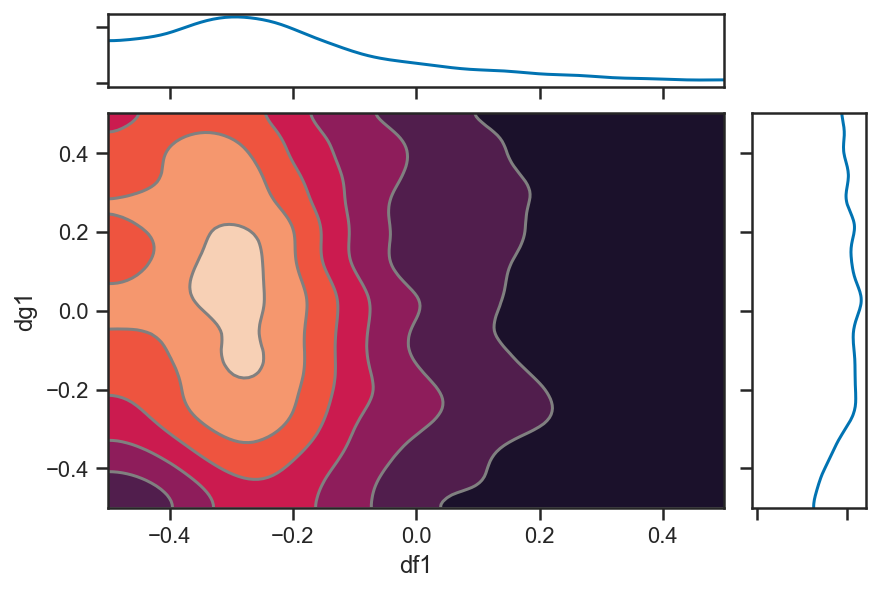

In [202]:
az.plot_joint(fit_constrained, var_names=['df1', 'dg1'], kind='kde')

De-correlated:

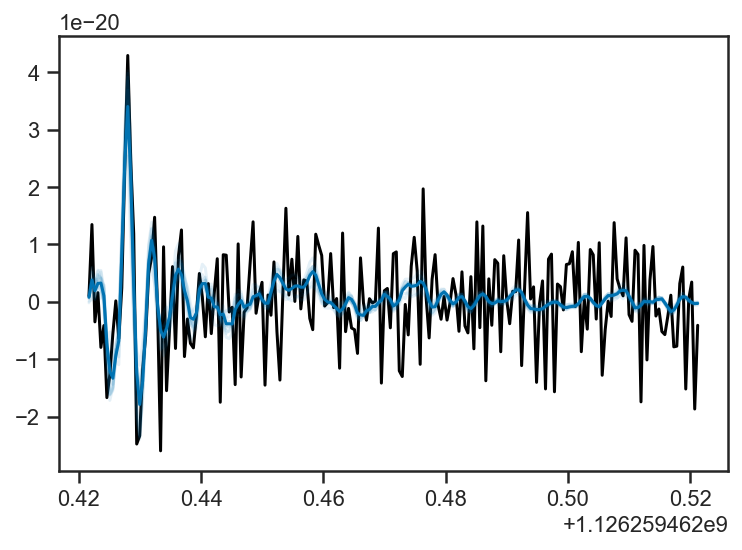

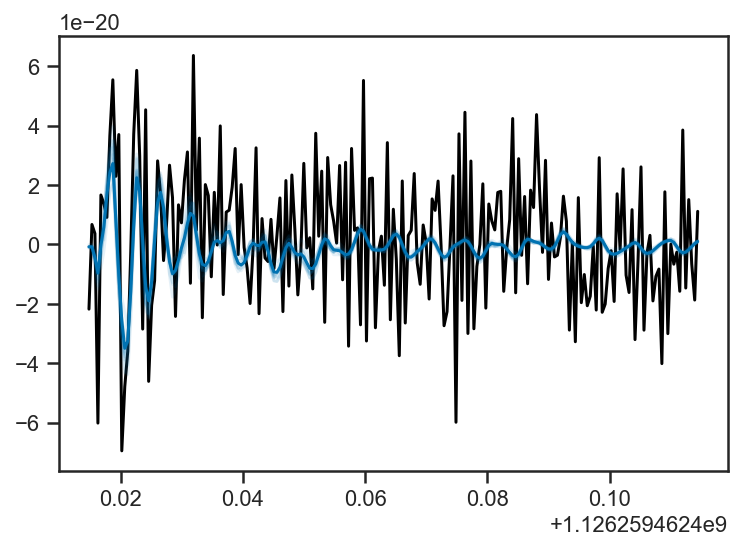

In [203]:
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), '-k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, fit_constrained.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)

figure()

plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), '-k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, fit_constrained.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)

Whitened:

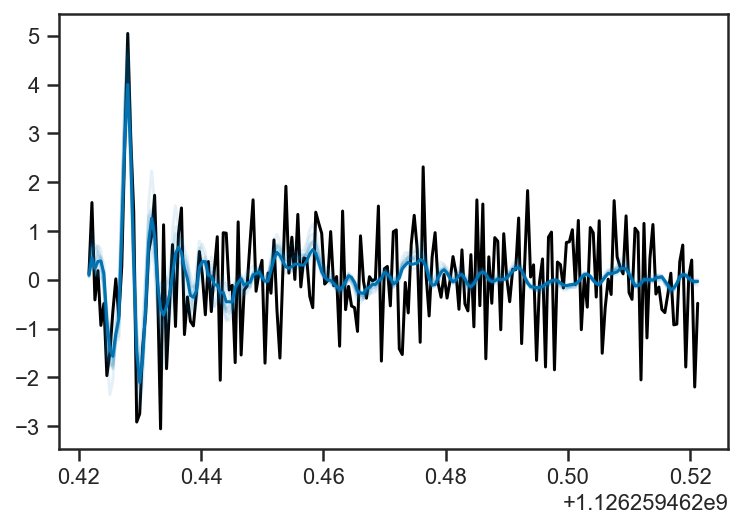

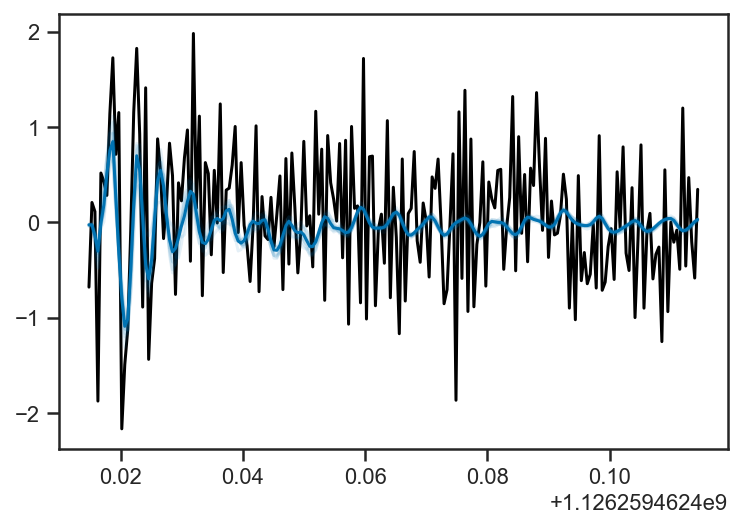

In [204]:
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), '-k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, fit_constrained.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)

figure()

plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), '-k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, fit_constrained.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)

Whitened residuals

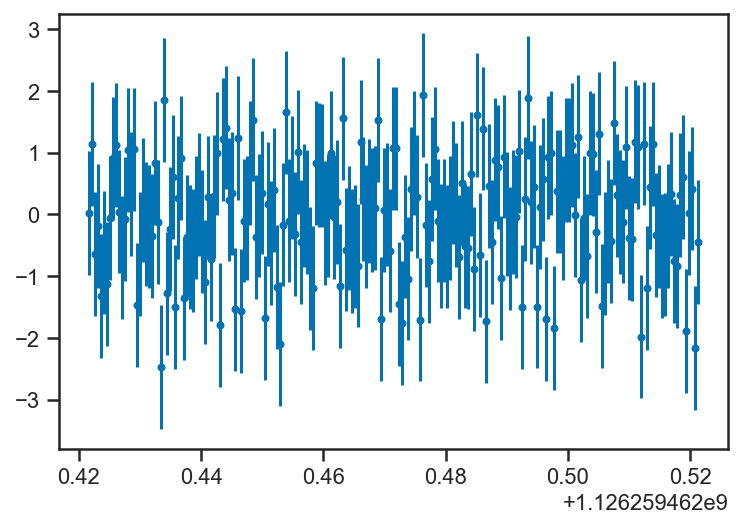

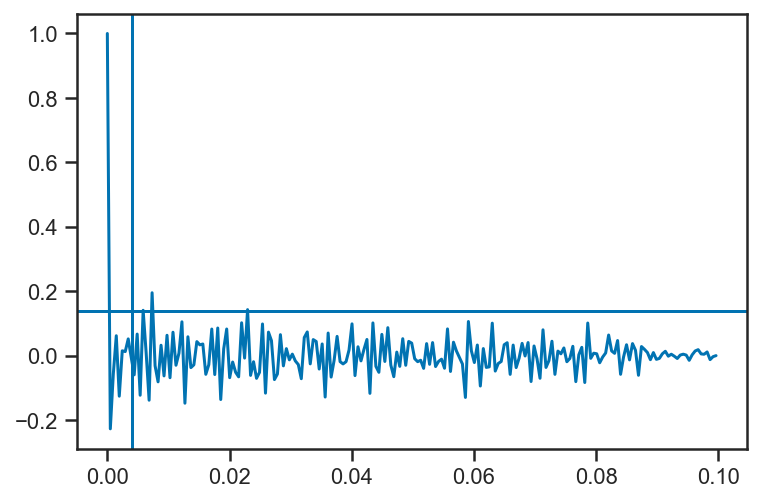

In [205]:
rH = Hfilt[I0H:I0H+Nanalyze] - fit_constrained.posterior.h_det.values[:,:,0,:]
wrH = np.linalg.solve(HL, mean(rH, axis=(0,1)))

errorbar(Htsfilt[I0H:I0H+Nanalyze], wrH, yerr=ones(Nanalyze), fmt='.')
figure()

acf = sig.correlate(wrH, wrH)
acf = ifftshift(acf)
acf /= acf[0]
acf = acf[:len(wrH)]

plot((Htsfilt[1]-Htsfilt[0])*arange(len(acf)), acf)
axhline(2/sqrt(len(acf)))
axvline(1/(fref*real(g220(0.7)[0]/(2*pi))))

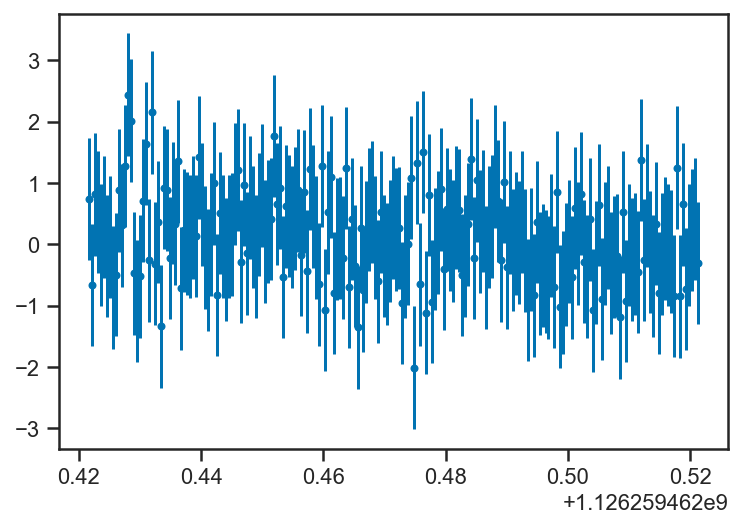

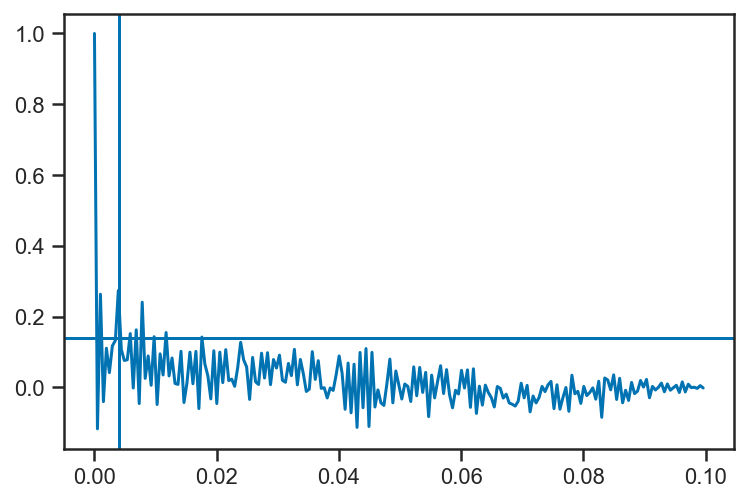

In [206]:
rL = Lfilt[I0H:I0H+Nanalyze] - fit_constrained.posterior.h_det.values[:,:,1,:]
wrL = np.linalg.solve(LL, mean(rL, axis=(0,1)))

errorbar(Ltsfilt[I0H:I0H+Nanalyze], wrL, yerr=ones(Nanalyze), fmt='.')
figure()

acf = sig.correlate(wrL, wrL)
acf = ifftshift(acf)
acf /= acf[0]
acf = acf[:len(wrL)]

plot((Ltsfilt[1]-Ltsfilt[0])*arange(len(acf)), acf)
axhline(2/sqrt(len(acf)))
axvline(1/(fref*real(g220(0.7)[0]/(2*pi))))

## Computing Fitting Formulae for Kerr Ringdown Modes

It is a bit un-satisfying to have to find the modes independently; let's instead compute some fitting formluae for the behaviour of the freq and damping rate so we can encode this in Stan.

In [46]:
chis = linspace(0, 1, 100)[1:-1]

In [47]:
freqs0 = array([fref*real(g220(c)[0])/(2*pi) for c in chis])
freqs1 = array([fref*real(g221(c)[0])/(2*pi) for c in chis])

gams0 = array([fref*abs(imag(g220(c)[0])) for c in chis])
gams1 = array([fref*abs(imag(g221(c)[0])) for c in chis])

In [48]:
x = log(freqs0/gams0)

In [49]:
M = column_stack((ones_like(x), x, x*x, x*x*x, x*x*x*x))
coeff_freq = np.linalg.lstsq(M, freqs1/freqs0)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


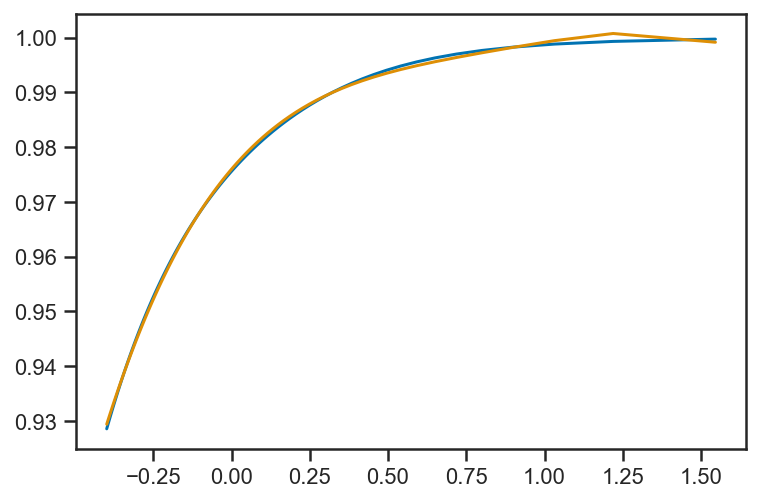

In [51]:
plot(x, freqs1/freqs0)
plot(x, np.dot(M, coeff_freq))

In [52]:
coeff_gam = np.linalg.lstsq(M, gams1/gams0)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


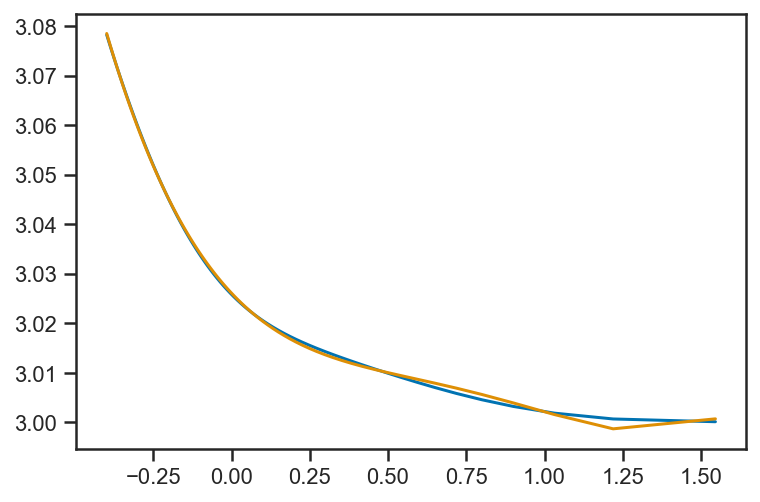

In [53]:
plot(x, gams1/gams0)
plot(x, np.dot(M, coeff_gam))

In [54]:
coeff_freq, coeff_gam

(array([ 0.97598764,  0.06695086, -0.09355756,  0.06990699, -0.02013998]),
 array([ 3.02608227, -0.06722567,  0.11394527, -0.10399184,  0.03334442]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1304aed30>,
      dtype=object)

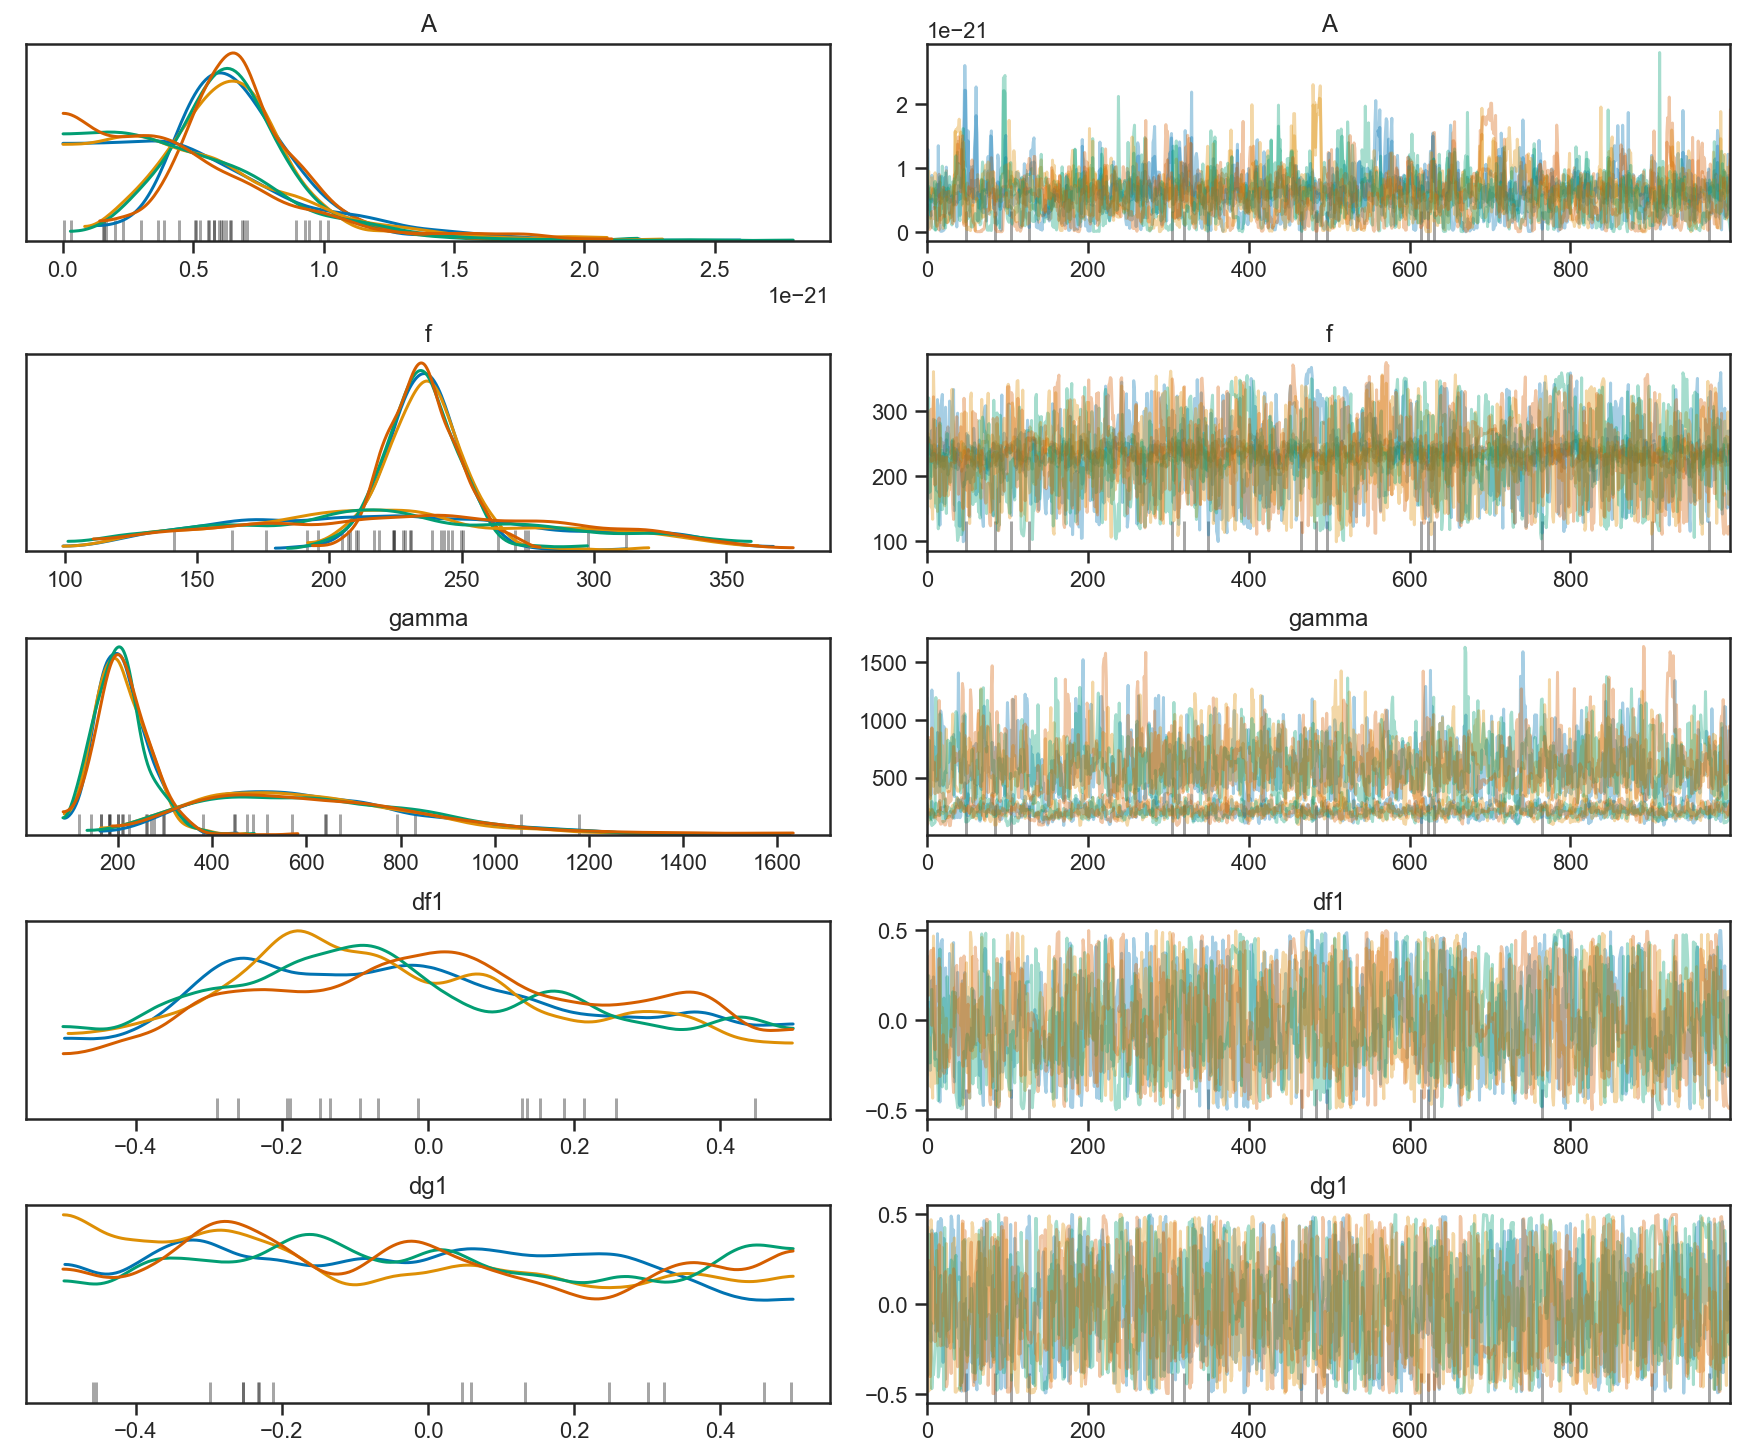

In [88]:
az.plot_trace(fit_constrained, var_names=['A', 'f', 'gamma', 'df1', 'dg1'], compact=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x134efbc50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ec0eba8>)

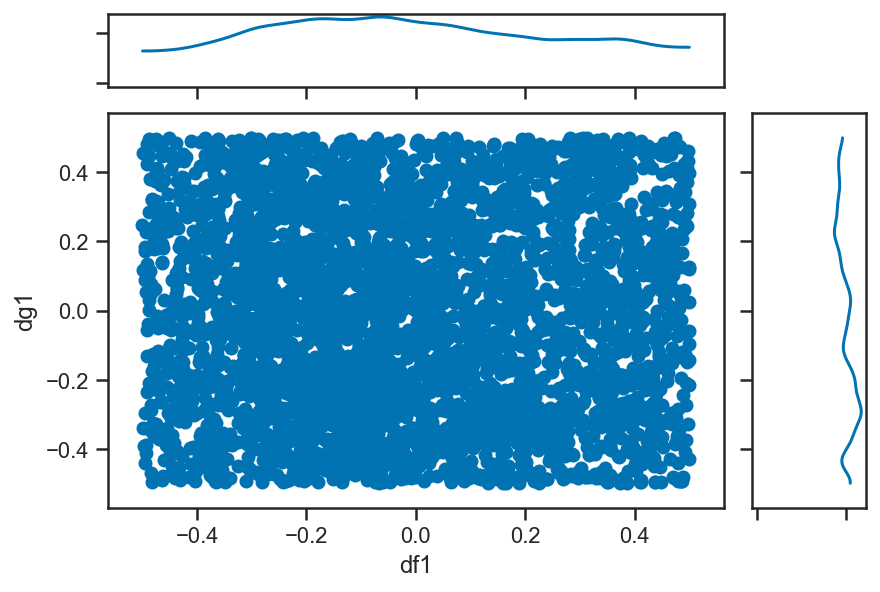

In [89]:
az.plot_joint(fit_constrained, var_names=['df1', 'dg1'])